# Neurosur workshop 2021


## Tutorial 1 - Vision with Convolutional Neural Networks (practice version)
#### Creator: Bahareh Tolooshams

Bahareh acknowledges Grace Lindsay for ideas explored in this tutorial.

---

## Tutorial objectives 

In this notebook, we learn about visual processing and convolutional neural networks.

 - Visualize effects of various filters (e.g., Blur, Gabor) on images.
 - Build and train a convolutional neural network for a classification task.
 - Visualize learned feature maps and filters. Compare them with Gabor filters (edge detector filters).
 - Learn about overfitting (train/test loss) in regular size deep neural networks.


---
## Imports and helper functions

Please execute the cell below to initialize the notebook environment

In [1]:
# @title
import numpy as np                 # import numpy
import scipy as sp                 # import scipy
import scipy.signal as spsignal
import matplotlib.pyplot as plt    # import matplotlib plot
import matplotlib.image as matimg  # import matplotlib image
import torch
import torch.nn as nn
import torchvision
import torchsummary
import os
import urllib
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset, TensorDataset

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

import warnings
warnings.filterwarnings("ignore")

In [2]:
#@title

def vis_images(kernel, img, img_proc, cmap="gray"):
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.imshow(kernel, cmap=cmap)
    plt.title("kernel")
    plt.subplot(132)
    plt.imshow(img, cmap=cmap)
    plt.title("image")
    plt.subplot(133)
    plt.imshow(img_proc, cmap=cmap)
    plt.title("filtered image")
    plt.show()
    return

def visualize_loss_acc(train_loss_all, test_loss_all, train_acc_all, test_acc_all):
    plt.figure(figsize=(12,3))
    plt.subplot(121)
    plt.plot(train_loss_all, color="red", label="Train")
    plt.plot(test_loss_all, color="green", label="Test")
    plt.legend()
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.subplot(122)
    plt.plot(train_acc_all, color="red", label="Train")
    plt.plot(test_acc_all, color="green", label="Test")
    plt.legend()
    plt.title("Accuracy [%]")
    plt.xlabel("Epochs")
    plt.ylim(0,100)
    plt.show()
    return

---
## EXERCISE 1: Create and apply blur filter

###1.1. Load and visualize an image 

- There are four images in `data_path = "https://github.com/btolooshams/deeplearning-workshop-neurosur-2021/raw/master/tutorials/data/t1/"` (e.g., `"1.png"`).
- Load an image using the function `imread` from `matplotlib.image`.
- Visualize the image using `imshow` from `matplotlib.pyplot`.

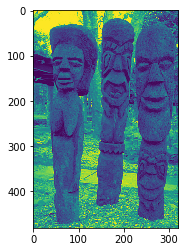

In [3]:
# load image
data_path = "https://github.com/btolooshams/deeplearning-workshop-neurosur-2021/raw/master/tutorials/data/t1"
img_path = os.path.join(data_path, "1.png")
path = urllib.request.urlopen(img_path)
img = matimg.imread(path)

# visualize image
plt.imshow(img)
plt.show()

###1.2. Create a function for 2D Gaussian distribution

- Use the equation $ G_{2D}(x,y,\sigma) = \frac{1}{2\pi \sigma^2} e^{-\frac{x^2 + y^2}{2\sigma^2}}$ to create a function to compute 2D Gaussian distribution.

In [4]:
# create Gaussian 2D function
def G2D(x, y, sigma=1):
    return ...

###1.3. Create a 2D receptive field given a distribution function

- `create_receptive_field` is created for this step.

In [5]:
# create receptive field
def create_receptive_field(func, kernel_size=10):
    receptive_field = np.zeros((kernel_size,kernel_size))
    for i in range(kernel_size):
        for j in range(kernel_size):
            x = i-kernel_size/2
            y = j-kernel_size/2
            receptive_field[i, j] = func(x, y);
    return receptive_field

sigma = 5
kernel_size = 25
filterFunc = lambda x,y:G2D(x,y,sigma)
kernel = create_receptive_field(filterFunc, kernel_size)

###1.4. Visualize the receptive field matrix

- Try various `sigma` and `kernel_size` to see how the kernel changes.

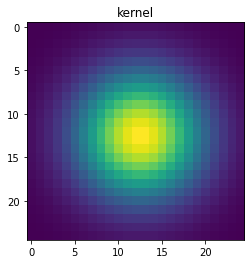

In [6]:
# visualize the receptive field
plt.imshow(kernel)
plt.title("kernel")
plt.show()

###1.5. Apply the filter on the image

- Print dimension of the image.
- Filter the image by the created kernel using the function `sp.signal.convolve2d`.
- The range of image is `(0,255)`. After filtering, map values greater than `255` into `255`, and less than `0` to `0`.

In [7]:
# perform convolution of img * kernel.
img_proc = ...
img_proc[img_proc>255] = 255
img_proc[img_proc<0] = 0

###1.6. Visualize the filtered image along with the filter and original image

- Try various `sigma` and `kernel_size` to see the effect of various filters on the image.

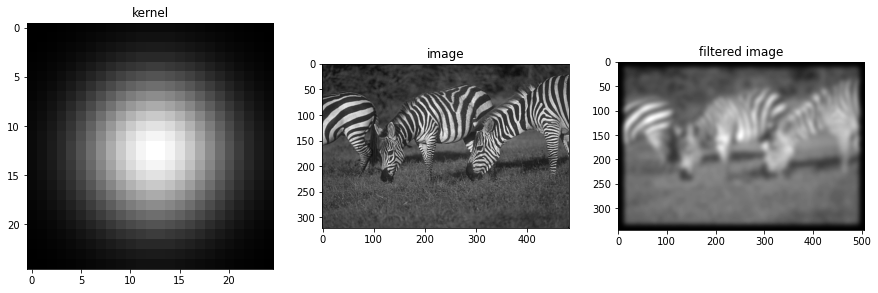

In [8]:
vis_images(kernel, img, img_proc, cmap="gray")

---
## EXERCISE 2: Repeat Exercise 1 and create the filter using mixture of Gaussian kernels.

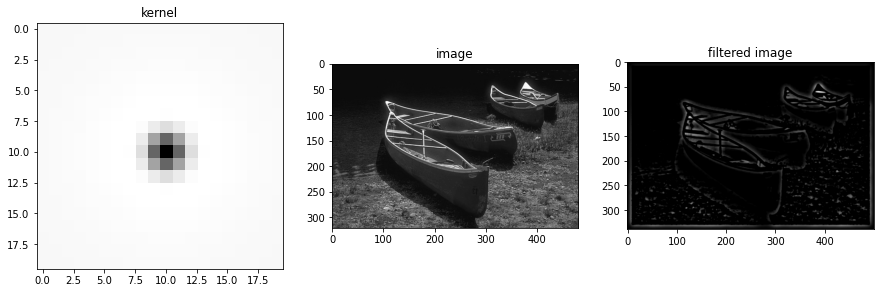

In [9]:
# load image
data_path = "https://github.com/btolooshams/deeplearning-workshop-neurosur-2021/raw/master/tutorials/data/t1"
img_path = os.path.join(data_path, "3.png")
path = urllib.request.urlopen(img_path)
img = matimg.imread(path)

# create difference of Gaussian filters
def diffG2D(sigma1=1, sigma2=5):
    return lambda x,y:G2D(x,y,sigma1) - G2D(x,y,sigma2)

# create receptive field
sigma1 = 5
sigma2 = 1
kernel_size = 20
filterFunc = ...
kernel = create_receptive_field(filterFunc, kernel_size)

# perform convolution of img * kernel.
img_proc = ...
img_proc[img_proc>255] = 255
img_proc[img_proc<0] = 0

# visualize
vis_images(kernel, img, img_proc, cmap="gray")

---
## EXERCISE 3: Repeat Exercise 1 and replace blur kernel with Gabor filters.


Create Gabor filters.

- Try various `theta` to see how the kernel changes and its effect on the image.
- Try various `kernel_size` or `sigma` and filter the image.

You should now have inuition on how Gabor filters are edge detectors.

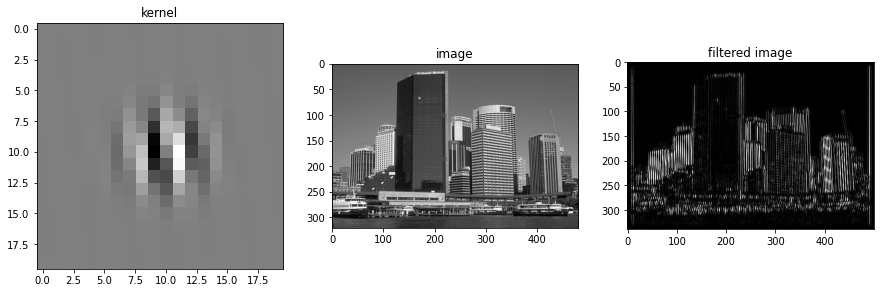

In [10]:
# load image
data_path = "https://github.com/btolooshams/deeplearning-workshop-neurosur-2021/raw/master/tutorials/data/t1"
img_path = os.path.join(data_path, "2.png")
path = urllib.request.urlopen(img_path)
img = matimg.imread(path)

# create Gabor filters
def Gabor(x, y, sigma, theta, f):
    return np.exp(-(x**2 + y**2)/(2 * sigma**2)) * np.sin(2 * np.pi * f * (x * np.cos(theta)+ y * np.sin(theta)))

# create receptive field
sigma = 2
theta = np.pi/10
f = 1
kernel_size = 20
filterFunc = lambda x,y:Gabor(x, y, sigma, theta, f)
kernel = create_receptive_field(filterFunc, kernel_size)

# perform convolution of img * kernel.
img_proc = ...
img_proc[img_proc>255] = 255
img_proc[img_proc<0] = 0

vis_images(kernel, img, img_proc, cmap="gray")

---
## EXERCISE 4: Build a CNN and train on natural images.


###4.1. Build a CNN

Here are basic computations (layers) of neural network.

1. Use `nn.Conv2D` to create conv layers. For all conv layers, use `kernel_size =3`, `stride=1`, and `bias = True`.
2. Use `nn.BatchNorm2d` for batch normalization layer.
3. Use `nn.ReLU()` as the activation function.
4. Use `nn.MaxPool2d` for max pooling.
5. Use `nn.Linear` for a fully connnected layer.

Build a convolutional neural network following the structure below.

- Layer 0:
    - conv layer from 3 input channels to c channels.
    - batch norm using c channel as input.
    - relu.
- Layer 1:
    - conv layer from c input channels to 2c channels.
    - batch norm using 2c channel as input.
    - relu.
    - maxpool of 2.
- Layer 2:
    - conv layer from 2c input channels to 4c channels.
    - batch norm using 4c channel as input.
    - relu.
    - maxpool of 2.
- Layer 3:
    - conv layer from 4c input channels to 8c channels.
    - batch norm using 8c channel as input.
    - relu.
    - maxpool of 2.
- Layer 4:
    - maxpool of 4.
    - flatten the latent representation. Use `Flatten()` function
    - use a fully connected layer from 8c channels into num_classes output channels, set the `bias = True`.

Upon creating the network, build a model from it and print its summary.

In [11]:
# build a CNN

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), x.size(1))
    
def make_cnn(c=4, num_classes=10):
    """ Returns a 5-layer CNN with width parameter c. """
    return nn.Sequential(
        # Layer 0
        ...
        ...
        nn.ReLU(),
        # Layer 1
        nn.Conv2d(c, c * 2, kernel_size=3, stride=1, padding=1, bias=True),
        ...
        ...
        ...,
        # Layer 2
        ...
        ...
        ...
        nn.MaxPool2d(2),
        # Layer 3
        ...
        ...
        ...
        ...
        # Layer 4
        ...
        Flatten(),
        ...
    )

# build a model
cnn_width = 4
model = make_cnn(c=cnn_width)
model.to(device)

# print summary of model
torchsummary.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 32, 32]             112
       BatchNorm2d-2            [-1, 4, 32, 32]               8
              ReLU-3            [-1, 4, 32, 32]               0
            Conv2d-4            [-1, 8, 32, 32]             296
       BatchNorm2d-5            [-1, 8, 32, 32]              16
              ReLU-6            [-1, 8, 32, 32]               0
         MaxPool2d-7            [-1, 8, 16, 16]               0
            Conv2d-8           [-1, 16, 16, 16]           1,168
       BatchNorm2d-9           [-1, 16, 16, 16]              32
             ReLU-10           [-1, 16, 16, 16]               0
        MaxPool2d-11             [-1, 16, 8, 8]               0
           Conv2d-12             [-1, 32, 8, 8]           4,640
      BatchNorm2d-13             [-1, 32, 8, 8]              64
             ReLU-14             [-1, 3

###4.2. Load `CIFAR-10` dataset and create torch datasets and dataloaders

- `CIFAR-10` is a dataset of $60{,}000$ images ($10$ classes of each $6{,}000$ images).To know more visit [here](https://www.cs.toronto.edu/~kriz/cifar.html).
- To speed-up up the training process and highlight the effect of overfitting, we use only a portion of the training set.

In [12]:
def load_cifar(num_train=50000, datadir="./data_cache"):

    train_ds = torchvision.datasets.CIFAR10(root=datadir, train=True, download=True)
    test_ds = torchvision.datasets.CIFAR10(root=datadir, train=False, download=True)

    def to_xy(dataset):
        X = (
            torch.Tensor(np.transpose(dataset.data, (0, 3, 1, 2))).float() / 255.0
        )  # [0, 1]
        Y = torch.Tensor(np.array(dataset.targets)).long()
        return X, Y

    X_tr, Y_tr = to_xy(train_ds)
    X_te, Y_te = to_xy(test_ds)
    
    X_tr = X_tr[:num_train]
    Y_tr = Y_tr[:num_train]

    return X_tr, Y_tr, X_te, Y_te

# load cifar dataset
num_train = 15000
X_tr, Y_tr, X_te, Y_te = load_cifar(num_train=num_train)

# create datasets
train_datasets = TensorDataset(X_tr, Y_tr)
test_datasets = TensorDataset(X_te, Y_te)

# create dataloaders using the dataset
train_dl = torch.utils.data.DataLoader(train_datasets, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
test_dl = torch.utils.data.DataLoader(train_datasets, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


###4.3. Build a SGD optimizer and cross entropy loss function.

- For the optimizer, specify its learning rate (lr), you should set `params=net.parameters()` ([help](https://pytorch.org/docs/stable/optim.html)).
- For loss, use `nn.CrossEntropyLoss()`.

In [13]:
num_epochs = 30
lr = 0.1

# optimizer
optimizer = ...

# loss function
loss_func = ...
loss_func = loss_func.to(device)

###4.4. Train.

Build `train_epoch` and `evaluate` function to call at every epoch.
Write a for loop and call your function.

- `(xB, yB)` are (images, labels).
- To run model in forward, do `model(xB)'.
- To go backward to compute gradient, use `loss.backward`.

In [ ]:
def train_epoch(model, train_dl, opt, loss_func, device="cpu", k=5000):
    model.train()
    model.to(device)

    netLoss = 0.0
    nCorrect = 0.0
    nTotal = 0.0
    for i, (xB, yB) in enumerate(tqdm(train_dl, disable=True)):
        opt.zero_grad()
        xB, yB = xB.to(device), yB.to(device)

        # pass forward
        outputs = ...
        
        # compute loss
        loss = loss_func(outputs, yB)
        
        # backward to compute gradient
        ...
        
        # update parameters using optimizer
        opt.step()
        
        # update total loss
        netLoss += loss.item() * len(xB)
        
        # compute accuracy
        with torch.no_grad():
            _, preds = torch.max(outputs, dim=1)

            nCorrect += (preds == yB).float().sum()
            nTotal += preds.size(0)
        
        # report acc and loss every k batches
        if (i + 1) % k == 0:
            train_acc = nCorrect / nTotal
            avg_loss = netLoss / nTotal
            print(
                f"\t [Batch {i+1} / {len(train_dl)}] Train Loss: {avg_loss:.3f} \t Train Acc: {train_acc:.3f}"
            )

    train_acc = nCorrect / nTotal
    avg_loss = netLoss / nTotal
    return avg_loss, train_acc


def evaluate(model, test_dl, loss_func, device="cpu"):
    model.eval()
    model.to(device)

    nCorrect = 0.0
    nTotal = 0.0
    net_loss = 0.0
    with torch.no_grad():
        for (xb, yb) in test_dl:
            
            # send data into device
            xb, yb = xb.to(device), yb.to(device)

            # pass forward
            outputs = ...
            
            # compute loss and accuracy
            loss = len(xb) * loss_func(outputs, yb)
            
            # compute accuracy
            _, preds = torch.max(outputs, dim=1)

            nCorrect += (preds == yb).float().sum()
            nTotal += preds.size(0)

            net_loss += loss

    acc = nCorrect.cpu().item() / float(nTotal)
    loss = net_loss.cpu().item() / float(nTotal)

    return loss, acc

# train

train_loss_all = []
test_loss_all = []

train_acc_all = []
test_acc_all = []
print(f"Start Training.")
for i in tqdm(range(num_epochs), disable=False):
    # train epoch
    train_loss, train_acc = train_epoch(model, train_dl, optimizer, loss_func, device)

    # evaluate
    test_loss, test_acc = evaluate(model, test_dl, loss_func, device)

    # add loss and acc to their lists
    ...
    ...
    
    ...
    ...
    
    print(
        f"Epoch {i}:\t Train Loss: {train_loss:.3f} \t Train Acc: {train_acc:.3f}\t Test Acc: {test_acc:.3f}"
    )

###4.5. Visualize feature maps and filters.

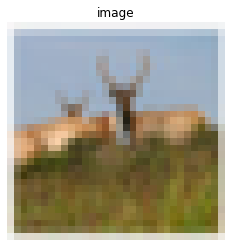

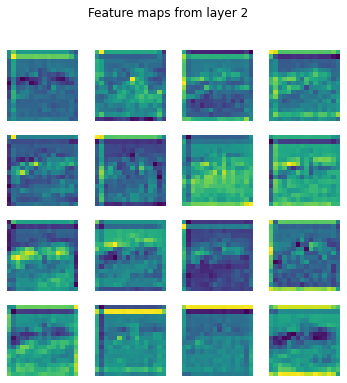

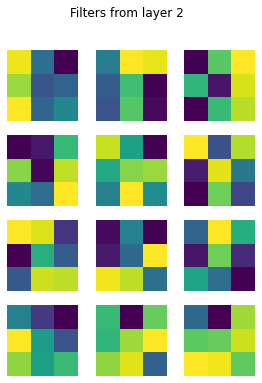

In [31]:
def get_one_example(dataloader):
    x, y = next(iter(dataloader))
    return torch.unsqueeze(x[0], dim=0)

def visualize_image(x):
    x = x.clone().detach().cpu().numpy()
    plt.figure()
    plt.imshow(np.moveaxis(x[0],0,2))
    plt.axis("off")
    plt.title("image")
    plt.show()
    return

def visualize_feature_maps(x, model, layer=0, device="cpu"):
    layer_org = np.copy(layer)
    if layer == 0:
        layer = 0
    elif layer == 1:
        layer = 3
    elif layer == 2:
        layer = 7
    elif layer == 3:
        layer = 11
        
    # build the network till specified layer
    intermediate_model = nn.Sequential(model[:layer+1])
    x = x.to(device)
    
    # pass data into network to get feature maps
    feature_maps = intermediate_model(x)
    feature_maps = feature_maps.clone().detach().cpu().numpy()
    
    # plot the features
    num_features = feature_maps.shape[1]
    a = np.int(np.floor(np.sqrt(num_features)))
    a = min(7, a)
    plt.figure(figsize=(a*1.5,a*1.5))
    ctr = 0
    for i in range(a**2):
        ctr += 1
        plt.subplot(a,a,ctr)
        plt.imshow(feature_maps[0,i,:,:])
        plt.axis("off")
    plt.suptitle("Feature maps from layer {}".format(layer_org))
    plt.show()
    return

def visualize_filters(model, layer=0):
    layer_org = np.copy(layer)
    if layer == 0:
        layer = 0
    elif layer == 1:
        layer = 3
    elif layer == 2:
        layer = 7
    elif layer == 3:
        layer = 11
    conv = model[layer].weight.clone().detach().cpu().numpy()
    
    a = np.int(np.ceil(np.sqrt(conv.shape[0])))
    a = min(10, a)
    b = np.int(np.ceil(np.sqrt(conv.shape[1])))
    b = min(10, b)
    plt.figure(figsize=(b*1.5,a*1.5))
    ctr = 0
    for i in range(a):
        for j in range(b):
            ctr += 1
            plt.subplot(a,b,ctr)
            plt.imshow(conv[i,j,:,:])
            plt.axis("off")
    plt.suptitle("Filters from layer {}".format(layer_org))
    plt.show()
    return

# get one example
x = get_one_example(train_dl)

# visualize the image
visualize_image(x)

k = 2
# compute features maps at layer k (range between 0-3)
# to save space, this function plots only max of 49 features.
# visualize feature maps
...

# visualize filters at layer k (range between 0-3)
# to save space, this function plots only max of 100 filters.
...

###4.6. Plot train/test loss and classification accuracy.

In [ ]:
# plot loss and accuracy
visualize_loss_acc(train_loss_all, test_loss_all, train_acc_all, test_acc_all)

---
## Wrap-up

In this notebook, we learn about convolution/filtering process and how to build/train convolutional neural network for classification. We visualized filters and feature maps learned by a CNN.